In [11]:
import sys
sys.path.append("C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\Tools")
sys.path

['',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\python36.zip',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\DLLs',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages\\cycler-0.10.0-py3.6.egg',
 'C:\\WorkingGround\\Anaconda\\envs\\ipykernel_py3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\houxi\\.ipython',
 'C:\\WorkingGround\\02450 Introduction to Machine Learning and Data Mining E17\\02450Toolbox_Python\\Tools']

In [94]:
import sqlite3
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from sklearn import model_selection
from sklearn import decomposition

from toolbox_02450 import clusterplot

from matplotlib.pyplot import figure, plot, legend, xlabel, show,annotate
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

In [39]:
#data = np.loadtxt('dataset.csv', skiprows=1, delimiter=',')
df_match = pd.read_csv('dataset.csv')
print ("All columns ", df_match.columns.values)

All columns  ['stage' 'home_team_goal' 'away_team_goal' 'possession_home' 'B365H'
 'B365D' 'B365A' 'BWH' 'BWD' 'BWA' 'IWH' 'IWD' 'IWA' 'LBH' 'LBD' 'LBA'
 'WHH' 'WHD' 'WHA' 'VCH' 'VCD' 'VCA' 'team_fifa_api_id_home'
 'buildUpPlaySpeed_home' 'buildUpPlayDribbling_home'
 'buildUpPlayPassing_home' 'buildUpPlayPositioningClass_home_isOrganised'
 'chanceCreationPassing_home' 'chanceCreationCrossing_home'
 'chanceCreationShooting_home'
 'chanceCreationPositioningClass_home_isOrganised' 'defencePressure_home'
 'defenceAggression_home' 'defenceTeamWidth_home' 'team_fifa_api_id_away'
 'buildUpPlaySpeed_away' 'buildUpPlayDribbling_away'
 'buildUpPlayPassing_away' 'buildUpPlayPositioningClass_away_isOrganised'
 'chanceCreationPassing_away' 'chanceCreationCrossing_away'
 'chanceCreationShooting_away'
 'chanceCreationPositioningClass_away_isOrganised' 'defencePressure_away'
 'defenceAggression_away' 'defenceTeamWidth_away' 'corner_home'
 'corner_away' 'cross_home' 'cross_away' 'throwin_home' 'throwin

In [71]:
home_wins = np.array((df_match['home_team_goal'] > df_match['away_team_goal']).tolist())
draws = np.array((df_match['home_team_goal'] == df_match['away_team_goal']).tolist())
match_results=list()
match_results_dict=dict()
for i ,match in enumerate(home_wins):
    if match:
        match_results.append(0)   ## home team win 
    elif draws[i]:
        match_results.append(1)   ## draw 
    else:
        match_results.append(2)  ## home team lose 

match_results_dict[0]='Home'
match_results_dict[1]='Draw'
match_results_dict[2]='Away'
df_match['Result']=match_results

In [134]:
in_match_features_list=['home_team_goal','away_team_goal','possession_home','corner_home',
                     'corner_away','cross_home','cross_away','throwin_home','throwin_away',
                     'shoton_home','shoton_away', 'shotoff_home', 'shotoff_away','foulcommit_home',
                     'foulcommit_away','ycard_home','ycard_away','rcard_home','rcard_away']

df_in_match=df_match[in_match_features_list]

In [135]:
X=df_match[in_match_features_list].as_matrix()

y=df_match['Result'].as_matrix()
print ("Using in game statistics to cluster match results ")

Using in game statistics to cluster match results 


### 1. Cluster Data by GMM and use cross-validation to estimate the number of components in the GMM. Interpret the extracted cluster centers

In [136]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
##Fit in game observations to 2D for visualization
X_pcaed = pca.transform(X)

d = {'PC1': X_pcaed[:,0], 'PC2': X_pcaed[:,1],'Result':df_match['Result'].values}
df_pcaed=pd.DataFrame(data=d)

In [137]:
df_pcaed.head()

,PC1,PC2,Result
0,8.831201,5.380457,2
1,0.133109,-17.947713,2
2,8.059941,-14.276453,2
3,-1.063217,-5.835442,1
4,-2.488674,-13.490563,0


C:\WorkingGround\Anaconda\envs\ipykernel_py3\lib\site-packages\sklearn\mixture\base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


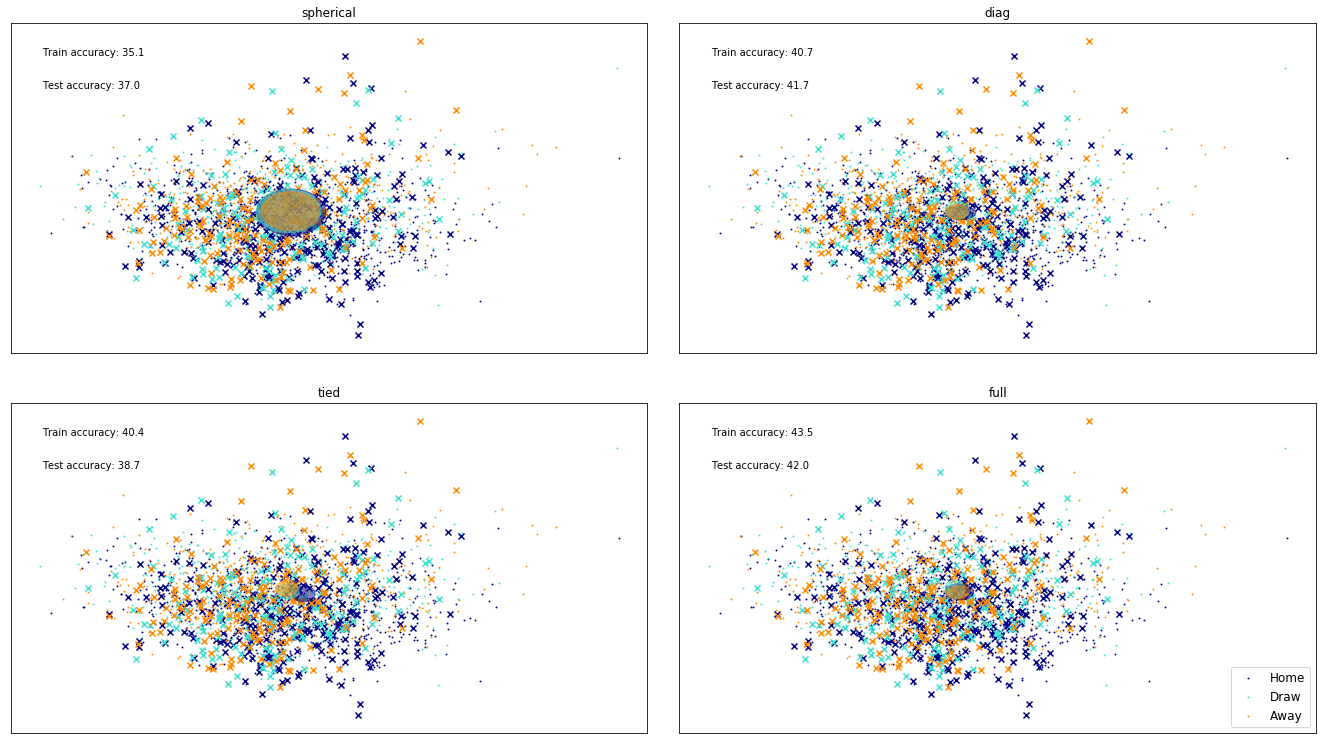

In [138]:
colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = model_selection.StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(X, y)))


X_train = X[train_index]
X_train_pcs=X_pcaed[train_index]
y_train = y[train_index]
X_test = X[test_index]
X_test_pcs=X_pcaed[test_index]
y_test = y[test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)


fig = plt.figure(0) 
fig.set_size_inches(18.5, 10.5, forward=True)
fig.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = df_pcaed[df_pcaed['Result']== n].as_matrix()
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,
                    label=match_results_dict[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test_pcs[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))

Fitting model for K=1
Fitting model for K=2
Fitting model for K=3
Fitting model for K=4
Fitting model for K=5
Fitting model for K=6
Fitting model for K=7
Fitting model for K=8
Fitting model for K=9
Fitting model for K=10


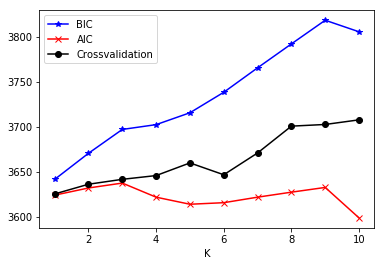

BIC, AIC TEST


In [11]:

N, M = X.shape

# Range of K's to try
KRange = range(1,11)
T = len(KRange)

covar_type = 'full'     # you can try out 'diag' as well
reps = 3                # number of fits with different initalizations, best result will be kept

# Allocate variables
BIC = np.zeros((T,))
AIC = np.zeros((T,))
CVE = np.zeros((T,))

# K-fold crossvalidation
CV = model_selection.KFold(n_splits=10,shuffle=True)

for t,K in enumerate(KRange):
        print('Fitting model for K={0}'.format(K))

        # Fit Gaussian mixture model
        gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X)

        # Get BIC and AIC
        BIC[t,] = gmm.bic(X)
        AIC[t,] = gmm.aic(X)

        # For each crossvalidation fold
        for train_index, test_index in CV.split(X):

            # extract training and test set for current CV fold
            X_train = X[train_index]
            X_test = X[test_index]

            # Fit Gaussian mixture model to X_train
            gmm = GaussianMixture(n_components=K, covariance_type=covar_type, n_init=reps).fit(X_train)

            # compute negative log likelihood of X_test
            CVE[t] += -gmm.score_samples(X_test).sum()
            

# Plot results

figure(1); 
plot(KRange, BIC,'-*b')
plot(KRange, AIC,'-xr')
plot(KRange, 2*CVE,'-ok')
legend(['BIC', 'AIC', 'Crossvalidation'])
xlabel('K')
show()

print('BIC, AIC TEST')